In [1]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fclusterdata
from scipy.spatial.distance import pdist, squareform
import numpy as np
from sklearn.cluster import DBSCAN
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from intervaltree import Interval, IntervalTree
from collections import Counter
from itertools import chain
from tqdm import tqdm
import os
import glob
import json
import time
import seaborn as sns
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
from statsmodels.stats.multitest import multipletests
from os import listdir
from os.path import isfile, join, basename
from io import StringIO
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### visualization on PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from adjustText import adjust_text

In [2]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [3]:
path_to_maps = os.getenv('PATH_TO_MAPS')

## 1. Select files with loops layouts

In [4]:
def read_bedpe(file_path, no_header=False):
    """
    The function reads BEDPE file and retains the standard fields
    """
    columns = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']
    if no_header:
        df = pd.read_csv(file_path, sep='\t', header=None)
    else:
        df = pd.read_csv(file_path, sep='\t')
    df['source'] = basename(file_path)
    return df

def process_chromosome(chrom, group, res, cluster_factor, dist_method, min_pts):
    coords = group.iloc[:, [1, 4]].values.astype(int)
    dist_matrix = squareform(pdist(coords, metric=dist_method))
    clustering = DBSCAN(eps=int(res * cluster_factor), min_samples=min_pts, metric='precomputed').fit(dist_matrix)
    group['cluster'] = clustering.labels_
    return chrom, group
    
def merge_bedpe_parallel(bedpe_files, res=15000, cluster_factor=2.5, select_col='intensity_mean', dist_method='cityblock', min_pts=1, merge=False, no_header=False, ready_merged=False):
    """
    The function identifies the clusters from BEDPE layout separated by 'cluster_factor' bins (counted from start1 A to start1 B)
    """
    if not ready_merged:
        with ProcessPoolExecutor(max_workers=10) as executor:
            futures = [executor.submit(read_bedpe, file_path, no_header) for file_path in bedpe_files]
            bedpe = pd.concat([future.result() for future in as_completed(futures)], ignore_index=True)
    else:
        bedpe = bedpe_files    
    if not (bedpe.iloc[:, 0] == bedpe.iloc[:, 3]).all(): # Confirm that all comparisons are intrachromosomal
        raise ValueError("All interactions must be intrachromosomal")
    chr_bedpe = {k: v for k, v in bedpe.groupby(bedpe.iloc[:, 0])}
    
    with ProcessPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(process_chromosome, chrom, group, res, cluster_factor, dist_method, min_pts) for chrom, group in chr_bedpe.items()]
        chr_bedpe = {chrom: group for chrom, group in [future.result() for future in as_completed(futures)]}

    if merge:        
        selected_bedpe = []
        for chrom, group in chr_bedpe.items():
            for cluster_id, cluster_group in group.groupby('cluster'):
                if cluster_id == -1:  # Noise points
                    selected_bedpe.append(cluster_group)
                else:
                    strongest_interaction = cluster_group[select_col].idxmax()
                    selected_bedpe.append(cluster_group.loc[[strongest_interaction]])    
        merged_bedpe = pd.concat(selected_bedpe, ignore_index=True)        
        merged_bedpe = merged_bedpe.sort_values(by=['chr1', 'start1'])
    else:
        for chrom in chr_bedpe:
            chr_bedpe[chrom]['cluster'] = [chrom + "_" + str(i) for i in chr_bedpe[chrom]['cluster']]
        merged_bedpe = pd.concat(chr_bedpe.values(), ignore_index=True)
    return bedpe, merged_bedpe



In [5]:
def merge_bedpe(bedpe_files, res=15000, cluster_factor = 2.5, select_col='intensity_mean', dist_method='cityblock', min_pts=1, merge=False, no_header = False, ready_merged=False):
    """
    The function identifies the clusters from BEDPE layout separated by 'cluster_factor' bins (counted from start1 A to start1 B)
    
    """
    
    bedpe = []
    columns = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']
    if not ready_merged:
        for file_path in bedpe_files:
            if no_header:
                df = pd.read_csv(file_path, sep='\t', header = None)
            else:
                df = pd.read_csv(file_path, sep='\t')
            df['source'] = basename(file_path)
            bedpe.append(df)
       
        bedpe = pd.concat(bedpe, ignore_index=True)
    else:
        bedpe = bedpe_files
    # Confirm that all comparisons are intrachromosomal
    if not (bedpe.iloc[:, 0] == bedpe.iloc[:, 3]).all():
        raise ValueError("All interactions must be intrachromosomal")
    
    # Split by chromosome
    chr_bedpe = {k: v for k, v in bedpe.groupby(bedpe.iloc[:, 0])}
    
    # Calculate distance and cluster for each chromosome
    for chrom in tqdm(chr_bedpe):
        coords = chr_bedpe[chrom].iloc[:, [1, 4]].values.astype(int)
        dist_matrix = squareform(pdist(coords, metric=dist_method))
        clustering = DBSCAN(eps=int(res*cluster_factor), min_samples=min_pts, metric='precomputed').fit(dist_matrix)
        chr_bedpe[chrom]['cluster'] = clustering.labels_        
        
    if merge:        
        # Split by groups within each chromosome and select the strongest interaction
        selected_bedpe = []
        for chrom, group in chr_bedpe.items():
            for cluster_id, cluster_group in group.groupby('cluster'):
                if cluster_id == -1:  # Noise points
                    selected_bedpe.append(cluster_group)
                else:                    
                    strongest_interaction = cluster_group[['intensity_mean']].idxmax().values[0]
                    cluster_group = cluster_group[cluster_group.index==strongest_interaction]
                    selected_bedpe.append(cluster_group)         
        # Combine into a single DataFrame
        merged_bedpe = pd.concat(selected_bedpe, ignore_index=True)        
        # Sort result by start position
        merged_bedpe = merged_bedpe.sort_values(by=[0, 1])
    else:
        for chrom in chr_bedpe:
            chr_bedpe[chrom]['cluster'] = [chrom+"_"+str(i) for i in chr_bedpe[chrom]['cluster']]
        merged_bedpe = pd.concat(chr_bedpe.values(), ignore_index=True)
    return bedpe, merged_bedpe


In [8]:
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_maps_expected = os.getenv('PATH_TO_EXPECTED_MAPS')
path_to_loops_clusters_data = "./loops_data/loops_clusters_data"
path_to_loops_clusters_temp_data = "./loops_data/loops_clusters_data/loops_clusters_temp_data"
path_to_loops_intensities = "./loops_data/loops_intensities/"
pattern = '13fdr_15000res_small_NaN5_final_sorted_with_intensity'
files = [f for f in listdir(path_to_loops_intensities) if pattern in f ]
number_of_files = 23
files.sort()
assert len(files) == number_of_files

## 2. Check if individual clusterings is needed

In [9]:
bedpe_files = [path_to_loops_intensities+bedpe_file for bedpe_file in files]
assert len(bedpe_files) == number_of_files
sum_contacts = 0
columns = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']
for file_path in bedpe_files:
    df = pd.read_csv(file_path, sep='\t')
    sum_contacts += df.num.nunique()
sum_contacts

389492

In [10]:
## Check how many dots are within one cluster for each individual file 
for df in bedpe_files:
    print(df)
    bedpe_test, merged_bedpe_test = merge_bedpe([df], res=15000, cluster_factor = 1.5, dist_method='cityblock', min_pts=1, merge=False)
    print(merged_bedpe_test.groupby('cluster').size().sort_values().max())
    print("_"*20)

./loops_data/loops_intensities/Ballerino2022_NES_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.65it/s]


3
____________________
./loops_data/loops_intensities/Ballerino2022_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.36it/s]


3
____________________
./loops_data/loops_intensities/Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.05it/s]


2
____________________
./loops_data/loops_intensities/Heffel_2T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.33it/s]


2
____________________
./loops_data/loops_intensities/Heffel_3T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 59.03it/s]


2
____________________
./loops_data/loops_intensities/Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.74it/s]


2
____________________
./loops_data/loops_intensities/Heffel_infant_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.07it/s]


3
____________________
./loops_data/loops_intensities/Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 74.33it/s]


2
____________________
./loops_data/loops_intensities/Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 99.54it/s]


2
____________________
./loops_data/loops_intensities/Lu2020_iPSC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 222.43it/s]


2
____________________
./loops_data/loops_intensities/Lu2020_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 18.77it/s]


2
____________________
./loops_data/loops_intensities/Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 105.59it/s]


2
____________________
./loops_data/loops_intensities/Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 66.46it/s]


2
____________________
./loops_data/loops_intensities/Rahman2023_FetalBrain_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 217.07it/s]


2
____________________
./loops_data/loops_intensities/Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 161.28it/s]


2
____________________
./loops_data/loops_intensities/Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.19it/s]


3
____________________
./loops_data/loops_intensities/Rajarajan_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.13it/s]


2
____________________
./loops_data/loops_intensities/Rajarajan_iPSC_Glia_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.46it/s]


2
____________________
./loops_data/loops_intensities/Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 48.90it/s]


2
____________________
./loops_data/loops_intensities/Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.51it/s]


3
____________________
./loops_data/loops_intensities/Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.75it/s]


3
____________________
./loops_data/loops_intensities/Zaghi2023_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.20it/s]


3
____________________
./loops_data/loops_intensities/Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.34it/s]


3
____________________


In [11]:
## Drop multiple dots within one cluster to retain one the most intense
path_to_save = './loops_data/loops_files_processed/'
index_to_drop_all = []
merged_bedpe_test_all = {}
for df in tqdm(bedpe_files):
    print(df)
    bedpe_test, merged_bedpe_test = merge_bedpe([df], res=15000, cluster_factor = 2.5, dist_method='cityblock', min_pts=1, merge=False)
    df_clusters = merged_bedpe_test.groupby('cluster').size().to_frame()
    cluster_with_several_dots = df_clusters[df_clusters[0] >1].index.tolist()
    index_to_drop_df = []
    if cluster_with_several_dots:
        for cluster in cluster_with_several_dots:
            index_to_drop = merged_bedpe_test[merged_bedpe_test.cluster == cluster].sort_values('intensity_mean', ascending=False).index[1:]
            index_to_drop_df.append(list(index_to_drop))
    print(len(index_to_drop_df))
    assert len(cluster_with_several_dots) <= len(index_to_drop_df)
    index_to_drop_df = [x for xs in index_to_drop_df for x in xs]
    name = df.split('/')[-1].split('.bed')[0]+"_removed_duplicates_noHeader.bed"
    merged_bedpe_test = merged_bedpe_test.drop(index_to_drop_df).reset_index(drop=True)
    merged_bedpe_test_all[name] = merged_bedpe_test
    merged_bedpe_test.to_csv(f'{path_to_save}/{name}', header = None, sep = '\t', index=False)

  0%|                                                                                                                                             | 0/23 [00:00<?, ?it/s]

./loops_data/loops_intensities/Ballerino2022_NES_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.43it/s]


489


  4%|█████▊                                                                                                                               | 1/23 [00:02<00:54,  2.50s/it]

./loops_data/loops_intensities/Ballerino2022_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.09it/s]


679


  9%|███████████▌                                                                                                                         | 2/23 [00:06<01:09,  3.31s/it]

./loops_data/loops_intensities/Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.82it/s]


552


 13%|█████████████████▎                                                                                                                   | 3/23 [00:09<01:00,  3.01s/it]

./loops_data/loops_intensities/Heffel_2T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.07it/s]


269


 17%|███████████████████████▏                                                                                                             | 4/23 [00:10<00:47,  2.49s/it]

./loops_data/loops_intensities/Heffel_3T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 59.11it/s]


107


 22%|████████████████████████████▉                                                                                                        | 5/23 [00:11<00:35,  1.98s/it]

./loops_data/loops_intensities/Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.91it/s]


356


 26%|██████████████████████████████████▋                                                                                                  | 6/23 [00:14<00:36,  2.13s/it]

./loops_data/loops_intensities/Heffel_infant_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.15it/s]


279


 30%|████████████████████████████████████████▍                                                                                            | 7/23 [00:16<00:36,  2.29s/it]

./loops_data/loops_intensities/Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 75.20it/s]


149


 35%|██████████████████████████████████████████████▎                                                                                      | 8/23 [00:17<00:28,  1.87s/it]

./loops_data/loops_intensities/Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 100.20it/s]


129


 39%|████████████████████████████████████████████████████                                                                                 | 9/23 [00:18<00:21,  1.54s/it]

./loops_data/loops_intensities/Lu2020_iPSC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



 43%|█████████████████████████████████████████████████████████▍                                                                          | 10/23 [00:18<00:15,  1.17s/it]

51
./loops_data/loops_intensities/Lu2020_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 18.36it/s]


313


 48%|███████████████████████████████████████████████████████████████▏                                                                    | 11/23 [00:22<00:21,  1.82s/it]

./loops_data/loops_intensities/Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 99.89it/s]


119


 52%|████████████████████████████████████████████████████████████████████▊                                                               | 12/23 [00:23<00:16,  1.50s/it]

./loops_data/loops_intensities/Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 61.16it/s]


241


 57%|██████████████████████████████████████████████████████████████████████████▌                                                         | 13/23 [00:24<00:14,  1.46s/it]

./loops_data/loops_intensities/Rahman2023_FetalBrain_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



 61%|████████████████████████████████████████████████████████████████████████████████▎                                                   | 14/23 [00:24<00:10,  1.12s/it]

41
./loops_data/loops_intensities/Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



 65%|██████████████████████████████████████████████████████████████████████████████████████                                              | 15/23 [00:25<00:07,  1.10it/s]

59
./loops_data/loops_intensities/Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.52it/s]


533


 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/23 [00:28<00:11,  1.60s/it]

./loops_data/loops_intensities/Rajarajan_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.70it/s]


405


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 17/23 [00:30<00:10,  1.80s/it]

./loops_data/loops_intensities/Rajarajan_iPSC_Glia_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.48it/s]


411


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 18/23 [00:32<00:09,  1.93s/it]

./loops_data/loops_intensities/Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 19/23 [00:34<00:07,  1.76s/it]

367
./loops_data/loops_intensities/Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.38it/s]


330


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20/23 [00:38<00:07,  2.56s/it]

./loops_data/loops_intensities/Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.02it/s]


615


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 21/23 [00:41<00:05,  2.52s/it]

./loops_data/loops_intensities/Zaghi2023_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.66it/s]


560


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 22/23 [00:43<00:02,  2.53s/it]

./loops_data/loops_intensities/Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity.bed



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.65it/s]


766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:46<00:00,  2.04s/it]


In [12]:
###check merging results
path = './loops_data/loops_files_processed/'
pattern = '_removed_duplicates'
not_pattern = '.bedped'
files = [f for f in listdir(path) if pattern in f and not_pattern not in f]
pattern = "_noHeader"
files = [f for f in listdir(path) if pattern in f and not_pattern not in f]
files.sort()

bedpe_files_merged = [path+bedpe_file for bedpe_file in files]
assert len(bedpe_files_merged) == 23

In [13]:
checker = []
for df in bedpe_files_merged:
    print(df)
    bedpe_test, merged_bedpe_test = merge_bedpe([df], res=15000, cluster_factor = 2.5, dist_method='cityblock', min_pts=1, merge=False)
    print(merged_bedpe_test.groupby('cluster').size().sort_values().max())
    checker.append(merged_bedpe_test.groupby('cluster').size().sort_values().max())
    print("_"*20)
assert set(checker) == set([1])

./loops_data/loops_files_processed/Ballerino2022_NES_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.15it/s]


1
____________________
./loops_data/loops_files_processed/Ballerino2022_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.62it/s]


1
____________________
./loops_data/loops_files_processed/Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.40it/s]


1
____________________
./loops_data/loops_files_processed/Heffel_2T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.22it/s]


1
____________________
./loops_data/loops_files_processed/Heffel_3T_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 66.40it/s]


1
____________________
./loops_data/loops_files_processed/Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.21it/s]


1
____________________
./loops_data/loops_files_processed/Heffel_infant_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.54it/s]


1
____________________
./loops_data/loops_files_processed/Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 85.12it/s]


1
____________________
./loops_data/loops_files_processed/Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 97.59it/s]


1
____________________
./loops_data/loops_files_processed/Lu2020_iPSC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 251.51it/s]


1
____________________
./loops_data/loops_files_processed/Lu2020_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 19.15it/s]


1
____________________
./loops_data/loops_files_processed/Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 111.95it/s]


1
____________________
./loops_data/loops_files_processed/Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 70.70it/s]


1
____________________
./loops_data/loops_files_processed/Rahman2023_FetalBrain_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 239.00it/s]

1


____________________
./loops_data/loops_files_processed/Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 167.13it/s]


1
____________________
./loops_data/loops_files_processed/Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.08it/s]


1
____________________
./loops_data/loops_files_processed/Rajarajan_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.86it/s]


1
____________________
./loops_data/loops_files_processed/Rajarajan_iPSC_Glia_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.36it/s]


1
____________________
./loops_data/loops_files_processed/Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 51.15it/s]


1
____________________
./loops_data/loops_files_processed/Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.48it/s]


1
____________________
./loops_data/loops_files_processed/Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.72it/s]


1
____________________
./loops_data/loops_files_processed/Zaghi2023_NPC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.27it/s]


1
____________________
./loops_data/loops_files_processed/Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.69it/s]

1
____________________


## 3. Perform clustering

In [14]:
def get_hg38_arms():
    """
    The function gets sizes of chromosomes arms by HG38 genome build
    
    """
    
    hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
    hg38_cens = bioframe.fetch_centromeres('hg38')
    hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
    return hg38_arms[hg38_arms.chrom!='chrM'].reset_index(drop=True)   
    
def check_merge_effects(merged_bedpe_clf_2_5):
    """
    The function prints the charasterictics of the identified clusters
    
    """
    
    #1
    description = "The number of dots in one Cluster from one Source"
    df_check = merged_bedpe_clf_2_5.groupby(['cluster', 'source']).size().to_frame().reset_index()
    print(description, df_check.groupby(0).size().to_frame())
    print("__"*14)
    
    #2
    description = "The MAX number of dots in all Cluster - "
    print(description, merged_bedpe_clf_2_5.groupby(['cluster']).size().max())
    print("__"*14)
    
    #3
    description = "The number of Clusters by the dots from different Sources "
    df_check["diff_sources"] = 1
    print(description, df_check.groupby(['cluster', "diff_sources"]).size().to_frame().groupby(0).size())
    print("__"*14)

    #4
    description = "The number of Clusters with the specific size"
    print(description, merged_bedpe_clf_2_5.groupby(['cluster']).size().to_frame().reset_index().groupby(0).size())

def get_cluster_borders(df, bin_size=15000):
    # Calculate min and max in a vectorized way
    min_start1 = df['start1'].min()
    max_end1 = df['end1'].max()
    min_start2 = df['start2'].min()
    max_end2 = df['end2'].max()
    
    # Define borders
    cluster_borders = {
        'chrom1': df['chrom1'].iloc[0],
        'start1': min_start1,
        'end1': max_end1,
        'start2': min_start2,
        'end2': max_end2,
        'chrom2': df['chrom2'].iloc[0]
    }
    
    # Calculate number of bins
    num_bins_left = (max_end1 - min_start1) // bin_size
    num_bins_right = (max_end2 - min_start2) // bin_size
    total_bins = num_bins_left * num_bins_right
    
    # Extend clusters
    extension = extend_clusters(total_bins, bin_size)
    extended_borders = {
        'chrom1': cluster_borders['chrom1'],
        'start1': min_start1 - extension,
        'end1': max_end1 + extension,
        'chrom2': cluster_borders['chrom2'],
        'start2': min_start2 - extension,
        'end2': max_end2 + extension
    }
    
    # Recalculate initnumber of bins with extended borders
    num_bins_left_extended = (extended_borders['end1'] - extended_borders['start1']) // bin_size
    num_bins_right_extended = (extended_borders['end2'] - extended_borders['start2']) // bin_size
    total_bins_extended = num_bins_left_extended * num_bins_right_extended
    
    return cluster_borders, total_bins, extended_borders, total_bins_extended

def extend_clusters(total_bins, bin_size=15000):
    if total_bins <= 2:
        return 2 * bin_size
    elif 3 <= total_bins <= 12:
        return bin_size
    else:
        return 0

In [36]:
### Obtain initial clusters
def get_merged_bedpe_with_filtering(bedpe_files_merged, file_to_filter, add_ipcs_rahman, selected_groups = ['iPSC-derived', 'Post-mortem'],make_parallel = False, cluster_factor = 2, remove_ipsc_glia=False):
    """
    Get merged BEDPE files from filtered list of files with loops
    """
    print('1. Getting merged bedpe') 
    
    bedpe_files_merged_filtered = [i for i in bedpe_files_merged if all(e not in i for e in file_to_filter)]
    if any("Lu" in i for i in file_to_filter):
        checker = {i:k for i,k in samples2groups.items() if "Lu" not in i}
    else:
        checker = samples2groups.copy()
    if remove_ipsc_glia:
        checker = {i:k for i,k in checker.items() if "Glia" not in i}
        print(checker)
    # print (f"These are bedpe - {bedpe_files_merged_filtered}")
    print (len(bedpe_files_merged_filtered), len([i for k,i in checker.items() if i in selected_groups])   )
    assert len(bedpe_files_merged_filtered) == len([i for k,i in checker.items() if i in selected_groups])    
        
    if add_ipcs_rahman:
        bedpe_files_merged_filtered+=[f'./loops_data/loops_files_processed/Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed']
    if make_parallel:
        bedpe_clf_2, merged_bedpe_clf_2 = merge_bedpe_parallel(bedpe_files_merged_filtered, cluster_factor = cluster_factor, no_header=True)
    else:
        bedpe_clf_2, merged_bedpe_clf_2 = merge_bedpe(bedpe_files_merged_filtered, cluster_factor = cluster_factor, no_header=True)
    merged_bedpe_clf_2 = merged_bedpe_clf_2.rename(columns = {0:"chrom1",1:"start1", 2:"end1",3:"chrom2", 4:"start2", 5:"end2", 6:"num", 7:"kernel",8:"intensity_all",9:"intensity_mean"})
    assert merged_bedpe_clf_2['source'].nunique() == len(bedpe_files_merged) - len(file_to_filter)
    assert set([i.split('/')[-1] for i in merged_bedpe_clf_2['source'].unique()]) == set([i.split('/')[-1] for i in bedpe_files_merged_filtered])
    return merged_bedpe_clf_2

def get_final_cluster_area_from_initial_clusters(merged_bedpe_clf_2):
    print('2. Getting final cluster area from initial clusters')
    cluster_to_area = {}
    for cluster, group in tqdm(merged_bedpe_clf_2.groupby('cluster')):
        unique_loops = group.iloc[:, :6].drop_duplicates()
        cluster_borders, total_bins, extended_borders, total_bins_extended = get_cluster_borders(unique_loops)
        cluster_to_area[cluster] = [cluster_borders, total_bins, extended_borders, total_bins_extended]
    assert len(cluster_to_area) == merged_bedpe_clf_2.groupby('cluster').size().to_frame().shape[0]
    return cluster_to_area

def give_cluster_stats(cluster_to_area):
    total_bins_extended_all, total_bins_all = [], []
    for cluster in cluster_to_area.keys():
        total_bins_extended_all.append(cluster_to_area[cluster][3])
        total_bins_all.append(cluster_to_area[cluster][1])
    print("Bins number (min / max): ",min(total_bins_all), max(total_bins_all))
    print("Extended bins number (min / max): ",min(total_bins_extended_all), max(total_bins_extended_all))
    print(f"Median size - {np.median(total_bins_extended_all)}")

    

In [16]:
### Adjust for extended clusters
def get_extended_coordinates(cluster_to_area):    
    cluster_to_area_only_extended = {i:k[2] for i,k in cluster_to_area.items()}
    cluster_to_area_df = pd.DataFrame(cluster_to_area_only_extended).T
    cluster_to_area_df = cluster_to_area_df.reset_index()
    cluster_to_area_df.rename(columns = {'index':'cluster_init'}, inplace=True)
    cluster_to_area_df = cluster_to_area_df[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'cluster_init']]
    return cluster_to_area_df

def build_interval_trees(df):
    trees = {chrom: IntervalTree() for chrom in pd.concat([df['chrom1'], df['chrom2']]).unique()}
    for _, row in df.iterrows():
        trees[row['chrom1']].add(Interval(row['start1'], row['end1'] + 1, row['cluster_init']))
        trees[row['chrom2']].add(Interval(row['start2'], row['end2'] + 1, row['cluster_init']))
    return trees
    
def get_bedpe_clusters(df):
    print('3. Perform clustering of the extended cluster area')
    trees = build_interval_trees(df)
    novel_clusters = {}    
    # Check for intersections
    for _, row in df.iterrows():
        for chrom, start, end in [(row['chrom1'], row['start1'], row['end1']), (row['chrom2'], row['start2'], row['end2'])]:
            tree = trees[chrom]
            intersects = tree[start:end + 1]
            for intersect in intersects:
                if intersect.data != row['cluster_init']:
                    # Check if the other end also intersects
                    other_chrom = row['chrom2'] if chrom == row['chrom1'] else row['chrom1']
                    other_start = row['start2'] if start == row['start1'] else row['start1']
                    other_end = row['end2'] if end == row['end1'] else row['end1']
                    other_tree = trees[other_chrom]
                    other_intersects = other_tree[other_start:other_end + 1]
                    if any(other_intersect.data == intersect.data for other_intersect in other_intersects):
                        # If the initial cluster is not already in a novel cluster, create a new one
                        if row['cluster_init'] not in novel_clusters:
                            novel_clusters[row['cluster_init']] = [row['cluster_init'], intersect.data]
                        # If the initial cluster is already in a novel cluster, add the intersecting cluster to it
                        elif intersect.data not in novel_clusters[row['cluster_init']]:
                            novel_clusters[row['cluster_init']].append(intersect.data)
    
    # If an initial cluster is not in a novel cluster, make it its own novel cluster
    for cluster in df['cluster_init']:
        if cluster not in novel_clusters:
            novel_clusters[cluster] = [cluster]
    return novel_clusters


def save_novel_clusters(novel_clusters, reduced_filtering, save_name):
    if reduced_filtering:
        name_appender = '_reduceFiltering'
    else:
        name_appender =''
    save_path_novel_clusters = f'{path_to_loops_clusters_data}/{save_name}_novel_clusters{name_appender}.pickle'
    with open(save_path_novel_clusters, 'wb') as f:
        pickle.dump(novel_clusters, f)

In [17]:
### Cluster filtering

def filter_clusters_by_number(group, mean_intensities, cutoff_by_number= 2):
    if group['source'].nunique() <=cutoff_by_number:
        return group.name   
            
def filter_clusters_by_number_by_intensity(group, mean_intensities, cutoff_by_number_by_intensity):
    """
    Filter clusters where only N (cutoff_by_number_by_intensity) source and the mean intensities of 50% included in it loops are lower than 25% for each source    
    """
    cnt=0
    if group['source'].nunique() <=cutoff_by_number_by_intensity:
        for source in group['source'].unique():
            df = group[group['source'] == source]            
            if (df['intensity_mean'] <= mean_intensities[source]).all():
                cnt+=1            
        if cnt>=int(round(cutoff_by_number_by_intensity*0.5)):
            return group.name

def filter_clusters_3(group, mean_intensities):
    cnt=0
    if group['source'].nunique() ==3:
        for source in group['source'].unique():
            df = group[group['source'] == source]            
            if (df['intensity_mean'] <= mean_intensities[source]).all():
                cnt+=1            
        if cnt>=1:
            return group.name

def filter_clusters_by_number_by_intensity_by_group(group, mean_intensities, group_source_counts, cutoff_by_number_by_intensity_by_group):
    cnt = 0
    required_unique_sources = int(round(group_source_counts.get(group.name[1], 3) *cutoff_by_number_by_intensity_by_group))
    if group['source'].nunique() <= required_unique_sources:
        for source in group['source'].unique():
            df = group[group['source'] == source]
            if (df['intensity_mean'] <= mean_intensities[source]).all():
                cnt += 1
        if cnt >= int(round(required_unique_sources*0.5)):
            return group.name


def create_mean_intensities(merged_bedpe_clf_2, cutoff=0.25):
    mean_intensities = {}
    for source in merged_bedpe_clf_2.source.unique():
        df = merged_bedpe_clf_2[merged_bedpe_clf_2.source == source]
        intensity_mean_list = df.intensity_mean.tolist()
        mean_intensities[source] = np.nanquantile(intensity_mean_list,cutoff)
    return mean_intensities

def filter_Lu_samples(merged_bedpe_clf_2):
    """
    Filter clusters where Lu is the only one source
    """
    cluster_sources = merged_bedpe_clf_2.groupby('cluster')['source'].agg(list)    
    specified_source = [i for i in merged_bedpe_clf_2.source.unique() if "Lu" in i]
    cluster_drop1 = cluster_sources[cluster_sources.apply(lambda x: x == specified_source)].index.tolist()    
    return cluster_drop1

def filter_clusters_by_number_in_group(merged_bedpe_clf_2, cutoff_by_number_by_group):
    groupped_by_cluster_group = merged_bedpe_clf_2[['cluster', 'group', 'source']].drop_duplicates().groupby(['cluster', 'group']).size().to_frame().reset_index()
    return groupped_by_cluster_group.groupby('cluster').filter(lambda x: all(x[0] <= cutoff_by_number_by_group)).cluster.unique().tolist()
     
def technical_filters(merged_bedpe_clf_2):
    return list(set([i for i in merged_bedpe_clf_2.cluster if  "_-1" in i]))
    
def filter_clusters_all(merged_bedpe_clf_2, cluster_to_area, save_name, name_appender, reduced_filtering=True, cutoff_by_number=1, cutoff_by_number_by_group=1, cutoff_by_number_by_intensity=3, cutoff_by_number_by_intensity_by_group=0.35):  
    print('4. Perform clusters filtering')
    mean_intensities = create_mean_intensities(merged_bedpe_clf_2, cutoff=0.25)
    group_source_counts = dict(Counter(samples2groups.values()))
    merged_bedpe_clf_2['group'] = merged_bedpe_clf_2['source'].map(loops2groups)
    print('4.1 Get filters')

    cluster_drop0 = technical_filters(merged_bedpe_clf_2)
    print(f"Filter 0: technical filter - {len(cluster_drop0)}")
    
    cluster_drop1 = filter_Lu_samples(merged_bedpe_clf_2)
    print(f"Filter 1: no Lu - {len(cluster_drop1)}")
    
    cluster_drop2 = merged_bedpe_clf_2.groupby('cluster').apply(filter_clusters_by_number, mean_intensities, cutoff_by_number=cutoff_by_number).dropna().values.tolist()
    print(f"Filter 2:  {cutoff_by_number} samples by cluster - ", len(cluster_drop2))
    
    cluster_drop3 = filter_clusters_by_number_in_group(merged_bedpe_clf_2, cutoff_by_number_by_group=cutoff_by_number_by_group)
    print(f"Filter 3: {cutoff_by_number_by_group} samples by cluster and group - ", len(cluster_drop3))
    
    all_cluster_drop = list(set(cluster_drop0+cluster_drop1+cluster_drop2+cluster_drop3))
    
    if not reduced_filtering:  
        cluster_drop4 = merged_bedpe_clf_2.groupby('cluster').apply(filter_clusters_by_number_by_intensity, mean_intensities, cutoff_by_number_by_intensity=cutoff_by_number_by_intensity).dropna().values.tolist()
        print(f"Filter 4*: {cutoff_by_number_by_intensity} samples by cluster and intensity - {len(cluster_drop4)}")   


        result = merged_bedpe_clf_2.groupby(['cluster', 'group']).apply(filter_clusters_by_number_by_intensity_by_group, mean_intensities, group_source_counts, cutoff_by_number_by_intensity_by_group=cutoff_by_number_by_intensity_by_group).dropna().tolist()
        cluster_drop5 = pd.DataFrame(result, columns=['cluster', 'group']).groupby('cluster').size().reset_index(name='count').query('count > 1').cluster.dropna().unique().tolist()
        print(f"Filter 5*: {cutoff_by_number_by_intensity_by_group} samples by cluster / intensity / group - {len(cluster_drop5)}") 
        
        all_cluster_drop = list(set(cluster_drop0+cluster_drop1+cluster_drop2+cluster_drop3+cluster_drop4+cluster_drop5))
    
    print("In total filter - ", len(all_cluster_drop))
    
    merged_bedpe_clf_2_filtered = merged_bedpe_clf_2[~merged_bedpe_clf_2.cluster.isin(all_cluster_drop)]
    print(f"Initial number of clusters - {merged_bedpe_clf_2.cluster.nunique()}")
    print(f"Final number of clusters - {merged_bedpe_clf_2_filtered.cluster.nunique()}")
    cluster_to_area_filtered = {key: value for key, value in cluster_to_area.items() if key not in all_cluster_drop}

    print('4.2 Saving files')
    
    merged_bedpe_clf_2_filtered.to_pickle(f'{path_to_loops_clusters_temp_data}/{save_name}_merged_bedpe_clf_2_filtered{name_appender}.pickle') #save
    pd.DataFrame(cluster_to_area_filtered).to_pickle(f'{path_to_loops_clusters_temp_data}/{save_name}_cluster_to_area_filtered{name_appender}.pickle') #save
    

    return merged_bedpe_clf_2_filtered, cluster_to_area_filtered


In [18]:
##Get missing clusters layout for each map
def get_source2map(merged_bedpe_clf_2_filtered, maps2loops):
    source2map = {}
    for k in merged_bedpe_clf_2_filtered.source.unique():
        name = k.split("_sampled_dots_final_")[0]
        map = [k for k,i in maps2loops.items() if name in i]
        assert len(map) == 1
        source2map[k] = map[0].split('/')[-1]
    return source2map
        
def get_individual_clusters_for_each_map(merged_bedpe_clf_2_filtered, cluster_to_area_filtered, save_name):
    print('5. Get all clusters layout (original + from identified clusters) for each map')
    
    all_clusters = {}
    hg38_arms = get_hg38_arms()
    maps_loaded = load_maps(merged_bedpe_clf_2_filtered)
    missing_clusters = get_missed_clusters(merged_bedpe_clf_2_filtered)
    
    for source in merged_bedpe_clf_2_filtered.source.unique():
        print(source.split('_sampled_dots_final_12000000maxloci_')[0])
        area3_to_3_final = calculate_all_clusters(source, maps_loaded, missing_clusters, merged_bedpe_clf_2_filtered, cluster_to_area_filtered, hg38_arms, save_name)
        all_clusters[source] = area3_to_3_final
        save_name_temp = save_name 
        if "CRISPRi_Scrambled_A_DpnII-HinfI" in source and "Rahman" in source:
            save_name_temp = "Rahman_iPSC_NeuNplus"
        area3_to_3_final.to_pickle(f'{path_to_loops_clusters_temp_data}/{save_name_temp}_{source}_temp_area3_to_3_final_reduceFiltering.pickle')
    
    merged_all_clusters = pd.DataFrame()
    for source in merged_bedpe_clf_2_filtered.source.unique():
        merged_all_clusters = pd.concat([all_clusters[source],merged_all_clusters]).reset_index(drop=True)
    assert merged_all_clusters.groupby('cluster').size().unique()[0] == merged_bedpe_clf_2_filtered.source.nunique()
    return merged_all_clusters

def load_maps(merged_bedpe_clf_2, directly=False):
    hg38_arms = get_hg38_arms()
    maps2loops = json.load(open('./loops_data/maps2loops_mapping.json'))
    source2map = get_source2map(merged_bedpe_clf_2, maps2loops)    
    maps_for_samples_loaded = {}
    if directly:
        sources = [i.split("/")[-1] for i in merged_bedpe_clf_2]
    else:
        sources = merged_bedpe_clf_2.source.unique()
    for source in tqdm(sources):
        maps_for_samples_loaded[source] = {}   
        clr = cooler.Cooler(f'{path_to_maps}/{source2map[source]}::/resolutions/{15000}')
        maps_for_samples_loaded[source]['cool'] = clr
        reduced_maps2loops = source2map[source].split('.mcool', 0)[0]
        try:
            maps_for_samples_loaded[source]['expected_per_chr'] = pd.read_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChr.pickle')
        except:
            print(f"Calculating expected for {source}")
            get_expected(source, source2map, hg38_arms)
            maps_for_samples_loaded[source]['expected_per_chr'] = pd.read_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChr.pickle')        


        try:  
            maps_for_samples_loaded[source]['expected_per_chr_arm'] = pd.read_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChrArm.pickle')

        except:
            print(f"Calculating expected for {source}")
            get_expected(source, source2map, hg38_arms, per_arm=True)
            maps_for_samples_loaded[source]['expected_per_chr_arm'] = pd.read_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChrArm.pickle')

   
    return maps_for_samples_loaded


def get_expected(source, source2map, hg38_arms, per_arm=False, nproc=17):  
    print(source, source2map[source])
    clr = cooler.Cooler(f'{path_to_maps}/{source2map[source]}::/resolutions/{15000}')
    reduced_maps2loops = source2map[source].split('.mcool', 0)[0]
    if per_arm:
        expected_per_chr = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=16)
        expected_per_chr.to_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChrArm.pickle')

    else:
        expected_per_chr = cooltools.expected_cis(clr, nproc=nproc)    
        expected_per_chr.to_pickle(f'{path_to_maps_expected}/{reduced_maps2loops}_perChr.pickle')


In [46]:
def get_missed_clusters(merged_bedpe_clf_2_filtered):
    print('5.1. Get missing clusters layout for each map')
    """
    Identify which clusters are not present in the orignial loop layout for each map
    """
    all_clusters = set(merged_bedpe_clf_2_filtered.cluster.unique())
    
    missing_clusters = {}
    for source in merged_bedpe_clf_2_filtered.source.unique():
        df = merged_bedpe_clf_2_filtered[merged_bedpe_clf_2_filtered.source == source]
        present_clusters = set(df['cluster'].unique().tolist())
        missing_clusters[source] = all_clusters - present_clusters
    
    for source, clusters in missing_clusters.items():
        print(f"Missing clusters for {source.split('_sampled_dots_final_12000000maxloci_')[0]}: {len(clusters)}")
    return missing_clusters

def calculate_all_clusters(source, maps_loaded, missing_clusters, merged_bedpe_clf_2_filtered, cluster_to_area_filtered, hg38_arms, save_name):    
    area3_to_3_all = calculate_loops_from_clusters(source, maps_loaded, missing_clusters, cluster_to_area_filtered, hg38_arms)
    area3_to_3_all_not_missing = calculate_loops_from_internal(source, merged_bedpe_clf_2_filtered, missing_clusters)
    
    area3_to_3_final = pd.concat([area3_to_3_all, area3_to_3_all_not_missing]).reset_index(drop=True)
    assert area3_to_3_final.cluster.nunique() == merged_bedpe_clf_2_filtered.cluster.nunique()
    assert area3_to_3_final.shape[0] == area3_to_3_final.cluster.nunique()
    name = source.split("_sampled_dots_final_12000000maxloci_0.13fdr")[0]
    if "CRISPRi_Scrambled_A_DpnII" in name:
        name = 'Rahman2023_iPSC_NeuNplus'
   
    area3_to_3_final.to_pickle(f"{path_to_loops_clusters_data}/calculated_clusters_{save_name}_{name}.pickle")
    return area3_to_3_final


def calculate_loops_from_clusters(source, maps_loaded, missing_clusters, cluster_to_area_filtered, hg38_arms):
    print('5.2. Get missing loops from clusters')
    maps_collection = maps_loaded[source]
    clr = maps_collection['cool']
    expected = maps_collection['expected_per_chr_arm']
    
    cluster_to_fill, cluster_to_fill_one_bin, mimic = create_arrays(missing_clusters, cluster_to_area_filtered, source)
    stack = get_pileup(clr, expected, mimic, cluster_to_fill_one_bin,  hg38_arms)
    area3_to_3_all = caulculate_full_array(cluster_to_fill, cluster_to_area_filtered, stack, source)
    assert area3_to_3_all.shape[0] == len(missing_clusters[source])
    return area3_to_3_all

def create_arrays(missing_clusters, cluster_to_area_filtered, source):
    print('5.2.1 Create an array')
    cluster_to_fill = missing_clusters[source]
    cluster_to_fill_one_bin = {i : make_one_bin(cluster_to_area_filtered, cluster) for i, cluster in enumerate(cluster_to_fill)}
    assert len(cluster_to_fill_one_bin) == len(cluster_to_fill)

    mimic = pd.DataFrame(cluster_to_fill_one_bin).T
    mimic = mimic.astype({'start1': int, 'end1': int, 'start2': int, 'end2': int})
    return cluster_to_fill, cluster_to_fill_one_bin, mimic

def make_one_bin(cluster_to_area_filtered, cluster):
    """
    The the upper right corner of missing clusters
    """
    mimic = cluster_to_area_filtered[cluster][2].copy()
    mimic["end1"] = mimic["start1"]+15000
    mimic["end2"] = mimic["start2"]+15000
    return mimic

    
def get_pileup(clr, expected, mimic, cluster_to_fill_one_bin,hg38_arms):
    """
    Get values on the contacts in missing clusters
    """
    print('5.2.2 Getting a pileup')
    stack = cooltools.pileup(clr, 
                         mimic,
                         hg38_arms,                                 
                         expected_df=expected, 
                         flank=210000,
                         nproc=17)

    stack[:, :, np.all(stack == 0, axis=(0,1))] = np.nan
    assert len(cluster_to_fill_one_bin) == stack.shape[0]
    stack = [select_lower_right_including_center(i) for i in stack]
    for i in stack:
        assert i.shape == (15, 15)
    return stack

def select_lower_right_including_center(arr):
    if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
        raise ValueError("The array must be square (same number of rows and columns).")    
    n = arr.shape[0]
    center_index = n // 2
    lower_right_subarray = arr[center_index:, center_index:] # Select the subarray from the center to the bottom-right corner
    return lower_right_subarray
    
def caulculate_full_array(cluster_to_fill, cluster_to_area_filtered, stack, source, bin_size=15000):
    """
    Get contacts data in the whole cluster area
    """
    print('5.2.3 Get contacts data in the whole cluster area')
    area3_to_3_all = pd.DataFrame()
    for i in tqdm(range(len(cluster_to_fill))):
        cluster = list(cluster_to_fill)[i]
        area_info = cluster_to_area_filtered[cluster][2]
        height = (area_info["end1"] - area_info["start1"]) // bin_size
        width = (area_info["end2"] - area_info["start2"]) // bin_size
        first_element = stack[i]
        rectangle = first_element[:height, :width]
        position, intensity_mean, intensity_all, status = find_max_mean_subarray(rectangle)
        area3_to_3 = create_3_to_3_bins(cluster_to_area_filtered[cluster][2], position, bin_size)
        area3_to_3['source'] = source
        if status !="failed":
            area3_to_3['intensity_all'] = [intensity_all.tolist()]
            area3_to_3['intensity_mean'] = intensity_mean
        else:
            area3_to_3['intensity_all'] = [np.empty(0)]
            area3_to_3['intensity_mean'] = None
        area3_to_3['cluster'] = cluster
        area3_to_3['calculation'] = 'from_cluster'
        
        area3_to_3_all = pd.concat([area3_to_3_all, area3_to_3]).reset_index(drop=True)
    return area3_to_3_all   

def create_3_to_3_bins(cluster_selected_area, position, bin_size = 15000):
    area3_to_3 = {}
    area3_to_3 = cluster_selected_area.copy()
    area3_to_3['start1'] = area3_to_3['start1']+bin_size*position[0]
    area3_to_3['end1'] = area3_to_3['start1']+bin_size*3
    area3_to_3['start2'] = area3_to_3['start2']+bin_size*position[1]
    area3_to_3['end2'] = area3_to_3['start2']+bin_size*3

    ### return to 15 kb resolution 
    area3_to_3['start1'] = area3_to_3['start1'] + bin_size
    area3_to_3['end1'] = area3_to_3['end1'] - bin_size
    area3_to_3['start2'] = area3_to_3['start2'] + bin_size
    area3_to_3['end2'] = area3_to_3['end2'] -bin_size
    
    return pd.DataFrame([area3_to_3])
    
## Get intensity in cluster
def find_max_mean_subarray(arr):
    status = 'success'        
    if arr.shape[0] < 3 or arr.shape[1] < 3:   # Check if the array is at least 3x3     
        return (0,0), 0, np.empty(0), 'failed'  
    
    max_mean = -np.inf # Initialize variables to keep track of the maximum mean and its position
    best_position = (0, 0)
    best_subarray = None  # Initialize variable to store the best subarray
    rows, cols = arr.shape # Get the dimensions of the array   
    
    for i in range(rows - 2): # Loop over all possible positions for the top-left corner of a 3x3 subarray
        for j in range(cols - 2):            
            subarray = arr[i:i+3, j:j+3] # Extract the 3x3 subarray            
            try: # Calculate the mean of the subarray
                if subarray.size >0:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        current_mean = np.nanmean(subarray)
            except:
                current_mean = None            
            if pd.isna(current_mean): # Update the maximum mean and position if the current mean is greater
                continue            
            if current_mean > max_mean:
                max_mean = current_mean
                best_position = (i, j)
                best_subarray = subarray  # Update the best subarray                
    if pd.isna(current_mean):
        status = 'failed'
    return best_position, max_mean, best_subarray, status 


In [47]:
def calculate_loops_from_internal(source, merged_bedpe_clf_2_filtered, missing_clusters):
    print('5.3. Get original loops for clusters')
    all_clusters = set(merged_bedpe_clf_2_filtered['cluster'].unique())
    not_missing = all_clusters - missing_clusters[source]
    sources_merged_bedpe_clf_2_filtered = merged_bedpe_clf_2_filtered[merged_bedpe_clf_2_filtered['source'] == source]
    sources_merged_bedpe_clf_2_filtered = sources_merged_bedpe_clf_2_filtered[sources_merged_bedpe_clf_2_filtered['cluster'].isin(not_missing)]
    sources_merged_bedpe_clf_2_filtered = sources_merged_bedpe_clf_2_filtered.sort_values(['cluster', 'intensity_mean'], ascending=[True, False])
    top_rows = sources_merged_bedpe_clf_2_filtered.groupby('cluster').head(1)
    top_rows = top_rows[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'source', 'intensity_all', 'intensity_mean', 'cluster']]
    top_rows['calculation'] = 'internal'
    area3_to_3_all_not_missing = top_rows.reset_index(drop=True)    
    assert area3_to_3_all_not_missing.shape[0] == len(not_missing)
    return area3_to_3_all_not_missing

In [48]:
### Apply final filter
def filter_final_clusters(merged_all_clusters, novel_clusters, save_name, name_appender):
    print('6. Get final cluster layout')
    mean_intensity = merged_all_clusters.groupby('cluster')['intensity_mean'].mean()
    filter_cluster = []
    for key in tqdm(novel_clusters.keys()):
        if len(novel_clusters[key]) > 1:
            to_cluster = novel_clusters[key]
            # Filter the clusters that are present in the DataFrame
            to_cluster = [cluster for cluster in to_cluster if cluster in mean_intensity.index]
            if to_cluster:
                # Get the mean intensities of the clusters
                intensities = mean_intensity.loc[to_cluster]
                # Sort the clusters by intensity and exclude the first one
                filter_cluster_one = intensities.sort_values(ascending=False).index[1:].tolist()
                filter_cluster.append(filter_cluster_one)
    filter_cluster = list(set([ x for xs in filter_cluster for x in xs ]))
    merged_all_clusters_filtered = merged_all_clusters[~merged_all_clusters.cluster.isin(filter_cluster)]
    merged_all_clusters.to_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")
        
    return merged_all_clusters_filtered 


In [49]:
### Loops post-processing
def get_median_values(merged_all_clusters):
    list_nanmedian = []
    for i in merged_all_clusters.intensity_all:
        if isinstance(i, str):
            data_str = i.replace('[', '').replace(']', '').replace("0.", '0.00000')
            string_i = StringIO(data_str)
            loaded_string_i = np.loadtxt(string_i)
            list_nanmedian.append(np.nanmedian(loaded_string_i))   
        else:
            list_nanmedian.append( np.nanmedian(i) )
    return list_nanmedian

In [50]:
### Visualize
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def plot_pca(pca, components_df, compontents, save_name=None, min_y=-300, max_y=500, min_x=-300, max_x=500):
    sns.set_style("white")
    plt.figure(figsize=(6,6)) 
    my_pal = {
        'Fetal neurons': '#a85858',
        'Fetal ES-derived neurons': '#8c5857',
        'Fetal NPC': '#d4adab',
        'Fetal stem-like cells': '#967978',
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Post-mortem neurons': '#034e91',
        'Post-mortem non-neurons': '#a87963',
        'iPSC-derived glia': '#d18c5a',
        "Primary neurons": "#77658c",
        'ES-derived neurons': '#53734c'
    }
    sns.scatterplot(data=components_df, s=120, x=compontents[0], y=compontents[1], 
                    hue="group",
                    palette = my_pal)
    abline(0, 0)    
    plt.axvline(0, 0,300, ls = '--', c = "lightgrey")
    plt.axhline(0, 0,300, ls = '--', c = "lightgrey")
    plt.ylim(min_y,max_y)
    plt.xlim(min_x,max_x)
    plt.legend(frameon=True, loc='best')
    PCA_order = {"PC1":0, "PC2":1, "PC3":2}
    plt.xlabel(f"{compontents[0]} {round(pca.explained_variance_ratio_[PCA_order[compontents[0]]].round(3)*100,1)}%")
    plt.ylabel(f"{compontents[1]} {round(pca.explained_variance_ratio_[PCA_order[compontents[1]]].round(3)*100,1)}%")
    
    texts = [plt.text(components_df[compontents[0]][line], components_df[compontents[1]][line], components_df["sample_simple"][line], horizontalalignment='left',
                  size='small', color='black')
             for line in range(0,components_df.shape[0])]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.4))
    if save_name:
        plt.savefig(f'./tads_visualizations/{save_name}_pca_loops_figure.pdf', dpi=600, bbox_inches='tight', format='pdf')
    plt.show()  

def make_pca_on_df(df_res_final, save_name ):
    prep_df = df_res_final.T.reset_index().fillna(0)
    X = prep_df[prep_df.columns.tolist()[1:]]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=6)
    components = pca.fit_transform(X_train_scaled)
    
    components_df = pd.DataFrame(components, columns = ["PC1","PC2","PC3","PC4","PC5","PC6"])
    components_df["sample"] =df_res_final.T.reset_index()["source"].tolist()
    df_columns = df_res_final.columns.tolist()
    group = []
    for i in df_columns:
        if 'NPC' in i:
            group.append('Stem-like cells')
        elif "Glia" in i and "iPSC" in i:
            group.append("iPSC-derived glia")
        elif 'iPSC' in i and "NeuNplus" in i:
            group.append('iPSC-derived neurons')
        elif 'iPSC' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'NES' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'Fetal' in i:
            group.append('Fetal neurons')        
        elif 'Heffel' in i:
            if "adult" in i:
                group.append('Post-mortem neurons')
            else:
                group.append('Fetal neurons')
        elif "NN" in i or "minus" in i:
            group.append('Post-mortem non-neurons')
        else:
            group.append('Post-mortem neurons')
    assert len(group) == len(df_columns) 
    components_df['group'] = group
    
    sample_simple = []
    for i in components_df["sample"]:
        if 'Rahman' in i:
            if "iPSC" in i or "Rahman2023_FetalBrain" in i:
                sample_simple.append('_'.join(i.split('_')[:2]))
            else:
                sample_simple.append(i.split('_')[0])
        elif 'Heffel' in i:
            sample_simple.append('_'.join(i.split('_')[:4]))
        elif 'Tian' in i and ("EN" in i or "IN" in i):
            if "Tian2023_NeuNplus_EN_IN" in i:
                sample_simple.append('_'.join(i.split('_')[:4]))
            else:
                sample_simple.append('_'.join(i.split('_')[:3]))
        elif 'Zaghi2023' in i or "Ballerino" in i or "Lu2020_iPSC_5kb_" in i:
            sample_simple.append('_'.join(i.split('_')[:2]))        
        elif 'Rajarajan' in i:
            if "Glia" in i:
                sample_simple.append('_'.join(i.split('_')[:3]))
            else:
                sample_simple.append('_'.join(i.split('_')[:2]))
        elif "years" in i:
            sample_simple.append(i.split('_29')[0])
        else:
            sample_simple.append(i.split('_')[0])
    components_df['sample_simple'] =sample_simple
    if save_name:
        if type(save_name) == str:
            components_df.to_csv(f'./loops_pca_data/{save_name}_pca_loops_data.tsv', index=False, sep='\t')
    
    return components_df, pca

def make_data_for_pca_from_clusters(merged_all_clusters, save_name, value_for_pca = "intensity_mean" ):
    merged_all_clusters_pivot = merged_all_clusters.pivot(index='cluster', columns='source', values=value_for_pca).dropna()
    assert len(set(list(merged_all_clusters_pivot.index))) == len((list(merged_all_clusters_pivot.index)))
    components_df, pca = make_pca_on_df(merged_all_clusters_pivot, save_name )
    components_df['sample_simple']+"_"+components_df["group"]

    data_for_pca = merged_all_clusters_pivot.T
    data_for_pca['source'] = (components_df['sample_simple']+"_"+components_df["group"].tolist()).tolist()
    data_for_pca = data_for_pca[[data_for_pca.columns.tolist()[-1]]+data_for_pca.columns.tolist()[:-1]]
    data_for_pca = data_for_pca.reset_index(drop=True)
    data_for_pca.index.name = None
    return components_df, pca, data_for_pca

def plot_all(merged_all_clusters, save_name):
    print("1. Plot based on mean intensities")
    components_df_median, pca_median, data_for_pca_median = make_data_for_pca_from_clusters(merged_all_clusters, value_for_pca = "intensity_median", save_name= save_name+"clusters_median")
    data_for_pca_median.to_csv(f'./loops_pca_data/{save_name}_clusters_median.tsv', index=False, sep='\t')
    for pca_sel in [['PC1','PC2'], ['PC1','PC3'],['PC2','PC3']]:
        plot_pca(pca_median, components_df_median, pca_sel,  min_y=-150, max_y=300, min_x=-200, max_x=300, save_name=None)
        
    print("2. Plot based on median intensities")
    components_df_mean, pca_mean, data_for_pca_mean = make_data_for_pca_from_clusters(merged_all_clusters, value_for_pca = "intensity_mean", save_name= save_name+"clusters_mean")
    data_for_pca_mean.to_csv(f'./loops_pca_data/{save_name}_clusters_mean.tsv', index=False, sep='\t')
    for pca_sel in [['PC1','PC2'], ['PC1','PC3'],['PC2','PC3']]:
        plot_pca(pca_mean, components_df_mean, pca_sel,  min_y=-150, max_y=300, min_x=-200, max_x=300, save_name=None)

## 4. Define common settings

In [25]:
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
path = './loops_data/loops_files_processed/'
pattern = '_removed_duplicates'
not_pattern = '.bedped'

pattern = "_noHeader"
name_appender=''
bedpe_files_merged = [path+f for f in listdir(path) if pattern in f and not_pattern not in f]
bedpe_files_merged.sort()
assert len(bedpe_files_merged) == number_of_files

In [26]:
loops2groups = {}
for i in bedpe_files_merged:
    if any(part in i for part in [ "NES","NPC","Glia"]):
        loops2groups[i.split('/')[-1]] = 'Stem-like cells'
    elif "iPSC_NeuNplus" in i or "culture_iPSC" in i:
        loops2groups[i.split('/')[-1]] = 'iPSC-derived neurons'
    elif "iPSC" in i and "NeuNplus" not in i:
        loops2groups[i.split('/')[-1]] = 'Stem-like cells'
    elif "_adult" in i:
        loops2groups[i.split('/')[-1]] = 'Post-mortem neurons'
    elif "Heffel" in i or "Fetal" in i:
       loops2groups[i.split('/')[-1]]= 'Fetal neurons'
    else:
        loops2groups[i.split('/')[-1]]= 'Post-mortem neurons'


In [29]:
maps2loops = json.load(open('./loops_data/maps2loops_mapping.json'))
samples = ['Ballerino2022_NES', 'Ballerino2022_NPC', 'Ballerino2022_iPSC_NeuNplus',
       'Heffel_2T', 'Heffel_3T', 'Heffel_adult', 'Heffel_infant',
       'Hu2021_NeuNplus', 'Li2022_iPSC_NeuNplus', 'Lu2020_iPSC',
       'Lu2020_iPSC_NeuNplus', 'Pletenev2024_NeuNplus',           
       'Rajarajan_iPSC_NeuNplus', 'Rahman2023_FetalBrain',
       'Rahman2023_NeuNplus', 'Rahman2023_iPSC_NeuNplus', 'Rajarajan_NPC_5kb',
       'Rajarajan_iPSC_Glia', 'Tian2023_NeuNplus', 'Wu2021_iPSC_NeuNplus',
       'Zaghi2023_NPC_5kb', 'Zaghi2023_iPSC_NeuNplus',
       'Our_data_iPSC_NeuNplus']

groups = ['Stem-like cells', 'Stem-like cells', 'iPSC-derived neurons', 
           'Fetal neurons', 'Fetal neurons', 'Post-mortem neurons', 'Fetal neurons',
          'Post-mortem neurons', 'iPSC-derived neurons', 'Stem-like cells', 
          'iPSC-derived neurons','Post-mortem neurons',           
          'iPSC-derived neurons',  'Fetal neurons', 
          'Post-mortem neurons',  'iPSC-derived neurons', 'Stem-like cells', 
          'Stem-like cells',  'Post-mortem neurons',  'iPSC-derived neurons', 
          'Stem-like cells', 'iPSC-derived neurons', 
          'iPSC-derived neurons']
assert len(groups) == len(samples) 
samples2groups = {i:k for i,k in zip(samples, groups)}
samples2groups_noLu = {i:k for i,k in zip(samples, groups) if "Lu" not in i}

In [30]:
group_source_counts = dict(Counter(samples2groups.values()))
group_source_counts

{'Stem-like cells': 6,
 'iPSC-derived neurons': 8,
 'Fetal neurons': 4,
 'Post-mortem neurons': 5}

In [51]:
def get_filtered_files(bedpe_files_merged, loops2groups, selected_groups):    
    file_to_filter = [i for i,k in loops2groups.items() if k not in selected_groups]
    reduced_filtering = False
    add_ipcs_rahman = False
    assert sum([k for i,k in group_source_counts.items() if i in selected_groups]) == len(bedpe_files_merged) - len(file_to_filter)
    if 'iPSC-derived neurons' in selected_groups:
        file_to_filter +=['Lu2020_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed']
    if 'Stem-like cells' in selected_groups:
        file_to_filter +=['Lu2020_iPSC_5kb_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed']
    
    assert len([i for i in file_to_filter if "Lu" in i ]) == 2
    return file_to_filter

def read_pickle_back(path):
    with open(path, 'rb') as handle:
        unserialized_data = pickle.load(handle)
    return unserialized_data
    
def fullstack_cluster_calculation(bedpe_files_merged, file_to_filter, save_name, add_ipcs_rahman,  selected_groups = ['iPSC-derived neurons', 'Post-mortem neurons'],make_parallel = False, reduced_filtering=True, known_files_num = False, remove_ipsc_glia=False):
    assert len(bedpe_files_merged) == number_of_files
    merged_bedpe_clf_2 = get_merged_bedpe_with_filtering(bedpe_files_merged, file_to_filter, add_ipcs_rahman=add_ipcs_rahman, selected_groups = selected_groups,make_parallel = make_parallel, remove_ipsc_glia=remove_ipsc_glia)
    if type(known_files_num) == int :
        assert merged_bedpe_clf_2.source.nunique() == known_files_num    
        
    cluster_to_area = get_final_cluster_area_from_initial_clusters(merged_bedpe_clf_2) # get cluster area from merged BEDPE
    save_cluster_to_area(cluster_to_area, save_name)
    give_cluster_stats(cluster_to_area) # get statistics on clusters
    cluster_to_area_df = get_extended_coordinates(cluster_to_area) # get extended cluster area from cluster_to_area dictionary
    save_cluster_to_area_df(cluster_to_area_df, save_name)    
    novel_clusters = get_bedpe_clusters(cluster_to_area_df) # calculate novel clusters from extended clusters    
    save_novel_clusters(novel_clusters, reduced_filtering, save_name) # save clusters 
    merged_bedpe_clf_2_filtered, cluster_to_area_filtered = filter_clusters_all(merged_bedpe_clf_2, cluster_to_area, save_name, name_appender, reduced_filtering) # filter clusters
    merged_all_clusters = get_individual_clusters_for_each_map(merged_bedpe_clf_2_filtered, cluster_to_area_filtered, save_name)
    merged_all_clusters = filter_final_clusters(merged_all_clusters, novel_clusters, save_name, name_appender)
    merged_all_clusters = pd.read_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")
    
    try:         
        list_nanmedian = get_median_values(merged_all_clusters)
        merged_all_clusters['intensity_median'] = list_nanmedian    
        merged_all_clusters.to_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")
        median_status = "median_calculated"
    except:
        print('Median calculation was not successful')
        median_status = "median_error"  
        
    if median_status == "median_error":
        list_nanmedian = get_median_values(merged_all_clusters)
        merged_all_clusters['intensity_median'] = list_nanmedian    
        merged_all_clusters.to_pickle(f"{path_to_loops_clusters_data}/{save_name}_calculated_clusters_all{name_appender}.pickle")
    
    plot_all(merged_all_clusters, save_name)
    return merged_all_clusters

#### Functions for saving

In [52]:
def save_cluster_to_area(cluster_to_area, save_name):
    flattened_data = []
    for key, value in cluster_to_area.items():
        for i in range(0, len(value), 2):
            record = value[i]
            record['key'] = key
            record['value'] = value[i+1]
            flattened_data.append(record)
    
    df = pd.DataFrame(flattened_data)
    df.to_excel(f'{path_to_loops_clusters_data}/cluster_to_area_{save_name}_back.xlsx', index=False)

def load_back_cluster_to_area(save_name):
    df = pd.read_excel(f'{path_to_loops_clusters_data}/cluster_to_area_{save_name}_back.xlsx')
    cluster_to_area = {}
    for _, row in df.iterrows():
        key = row['key']
        if key not in cluster_to_area:
            cluster_to_area[key] = []    
        row['start1'] = int(row['start1'])
        row['end1'] = int(row['end1'])
        row['start2'] = int(row['start2'])
        row['end2'] = int(row['end2'])
        row['value'] = int(row['value'])
        
        value = row['value']
        row = row.drop(['key', 'value']).to_dict()
        
        cluster_to_area[key].append(row)
        cluster_to_area[key].append(value)
    return cluster_to_area

def save_cluster_to_area_df(cluster_to_area_df, save_name):
    cluster_to_area_df.to_excel(f'{path_to_loops_clusters_data}/cluster_to_area_df_{save_name}_back.xlsx', index=False) 

def load_back_cluster_to_area_df(save_name):
    return pd.read_excel(f'{path_to_loops_clusters_data}/cluster_to_area_df_{save_name}_back.xlsx') 


def load_back_novel_clusters(save_name):
    save_path_novel_clusters = f'{path_to_loops_clusters_data}/{save_name}_novel_clusters{name_appender}.pickle'
    with open(save_path_novel_clusters, 'rb') as f:
        novel_clusters = pickle.load(f)
    return novel_clusters

### 2.1. Perform clustering - Post_mortem neurons vs iPSC-derived neurons

In [44]:
save_name = "loops_clustering_post_mortem_vs_iPSC_derived"
selected_groups=['iPSC-derived neurons', 'Post-mortem neurons']
file_to_filter = [i for i,k in loops2groups.items() if k not in selected_groups]
reduced_filtering = False
add_ipcs_rahman = False
file_to_filter = get_filtered_files(bedpe_files_merged, loops2groups, selected_groups)


1. Getting merged bedpe
12 12
2. Getting final cluster area from initial clusters


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79494/79494 [03:19<00:00, 398.55it/s]


Bins number (min / max):  1 110
Extended bins number (min / max):  14 110
Median size - 25.0
3. Perform clustering of the extended cluster area
4. Perform clusters filtering
4.1 Get filters
Filter 0: technical filter - 0
Filter 1: no Lu - 0
Filter 2:  1 samples by cluster -  51611
Filter 3: 1 samples by cluster and group -  54088
Filter 4*: 3 samples by cluster and intensity - 3458
Filter 5*: 0.35 samples by cluster / intensity / group - 524
In total filter -  57259
Initial number of clusters - 79494
Final number of clusters - 22235
4.2 Saving files
5. Get all clusters layout (original + from identified clusters) for each map


  0%|                                                                                                                                             | 0/12 [00:00<?, ?it/s]

Calculating expected for Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Hu2021_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Hu2021_NeuNplus.sampled_exact.mcool


  8%|███████████                                                                                                                          | 1/12 [00:25<04:44, 25.90s/it]

Calculating expected for Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Li2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Li2022_iPSC_NeuNplus.sampled_exact.mcool


 17%|██████████████████████▏                                                                                                              | 2/12 [00:48<03:59, 23.93s/it]

Calculating expected for Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Ballerino2022_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Ballerino2022_iPSC_NeuNplus.sampled_exact.mcool


 25%|█████████████████████████████████▎                                                                                                   | 3/12 [01:04<03:04, 20.47s/it]

Calculating expected for Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Our_data_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Our_data_iPSC_NeuNplus.drop_diag.5kb.mcool.sampled_exact.mcool


 33%|████████████████████████████████████████████▎                                                                                        | 4/12 [01:26<02:46, 20.84s/it]

Calculating expected for Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Rahman2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Rahman2023_NeuNplus.sampled_exact.mcool


 42%|███████████████████████████████████████████████████████▍                                                                             | 5/12 [01:50<02:35, 22.19s/it]

Calculating expected for Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Heffel_adult_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Heffel_adult.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool


 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 6/12 [02:13<02:14, 22.35s/it]

Calculating expected for Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Pletenev2024_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Pletenev2024_NeuNplus.sampled_exact.mcool


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                       | 7/12 [02:38<01:55, 23.14s/it]

Calculating expected for Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Rajarajan_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Rajarajan_iPSC_NeuNplus.sampled_exact.mcool


 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8/12 [03:01<01:32, 23.23s/it]

Calculating expected for Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 9/12 [03:26<01:11, 23.75s/it]

Calculating expected for Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Wu2021_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Wu2021_iPSC_NeuNplus.sampled_exact.mcool


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 10/12 [03:53<00:49, 24.79s/it]

Calculating expected for Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Zaghi2023_iPSC_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Zaghi2023_iPSC_NeuNplus.sampled_exact.mcool


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 11/12 [04:10<00:22, 22.44s/it]

Calculating expected for Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed
Tian2023_NeuNplus_sampled_dots_final_12000000maxloci_0.13fdr_15000res_small_NaN5_final_sorted_with_intensity_removed_duplicates_noHeader.bed Tian2023_NeuNplus.EN_IN.29_42_58_years.2000_cells.sampled_exact.mcool


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:31<00:00, 22.66s/it]


5.1. Get missing clusters layout for each map
Missing clusters for Hu2021_NeuNplus: 13970
Missing clusters for Li2022_iPSC_NeuNplus: 13958
Missing clusters for Ballerino2022_iPSC_NeuNplus: 8475
Missing clusters for Our_data_iPSC_NeuNplus: 14915
Missing clusters for Rahman2023_NeuNplus: 16387
Missing clusters for Heffel_adult: 10687
Missing clusters for Pletenev2024_NeuNplus: 12034
Missing clusters for Rajarajan_iPSC_NeuNplus: 10164
Missing clusters for Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI: 8226
Missing clusters for Wu2021_iPSC_NeuNplus: 8965
Missing clusters for Zaghi2023_iPSC_NeuNplus: 6923
Missing clusters for Tian2023_NeuNplus: 9875
Hu2021_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13970/13970 [01:41<00:00, 138.14it/s]


5.3. Get original loops for clusters
Li2022_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13958/13958 [01:28<00:00, 157.82it/s]


5.3. Get original loops for clusters
Ballerino2022_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8475/8475 [00:40<00:00, 211.09it/s]


5.3. Get original loops for clusters
Our_data_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14915/14915 [02:11<00:00, 113.82it/s]


5.3. Get original loops for clusters
Rahman2023_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16387/16387 [02:50<00:00, 96.29it/s]


5.3. Get original loops for clusters
Heffel_adult
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10687/10687 [01:33<00:00, 114.85it/s]


5.3. Get original loops for clusters
Pletenev2024_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12034/12034 [01:48<00:00, 111.22it/s]


5.3. Get original loops for clusters
Rajarajan_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10164/10164 [01:27<00:00, 116.18it/s]


5.3. Get original loops for clusters
Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8226/8226 [00:57<00:00, 142.34it/s]


5.3. Get original loops for clusters
Wu2021_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8965/8965 [01:09<00:00, 128.97it/s]


5.3. Get original loops for clusters
Zaghi2023_iPSC_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6923/6923 [00:48<00:00, 144.22it/s]


5.3. Get original loops for clusters
Tian2023_NeuNplus
5.2. Get missing loops from clusters
5.2.1 Create an array
5.2.2 Getting a pileup
5.2.3 Get contacts data in the whole cluster area


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9875/9875 [01:21<00:00, 121.47it/s]


5.3. Get original loops for clusters
6. Get final cluster layout


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79494/79494 [00:21<00:00, 3730.69it/s]
/opt/anaconda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


1. Plot based on mean intensities


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


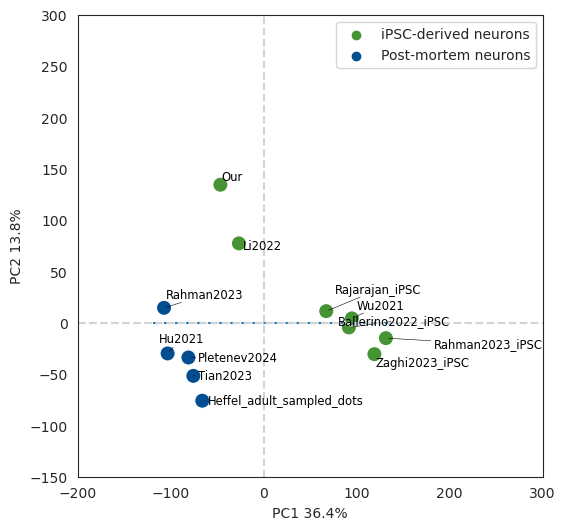

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


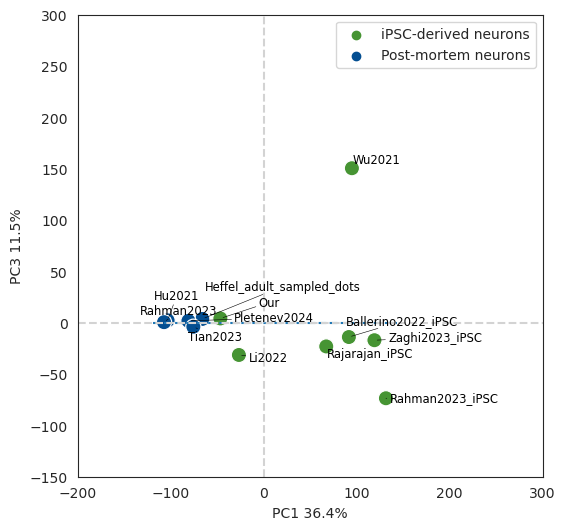

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


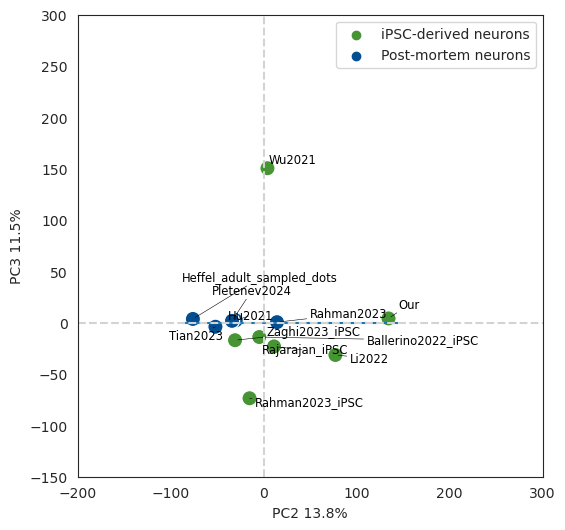

2. Plot based on median intensities


               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


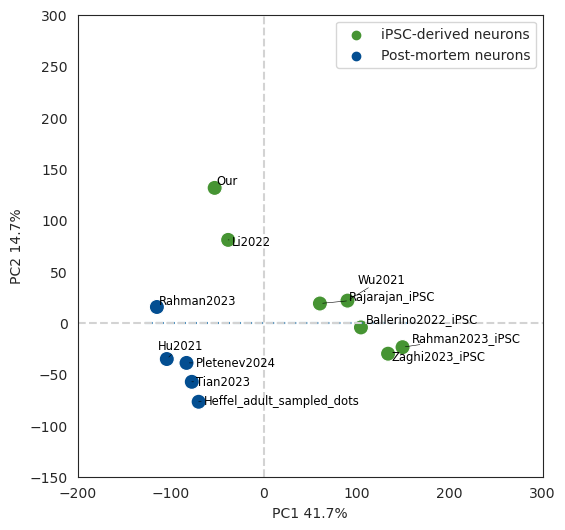

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


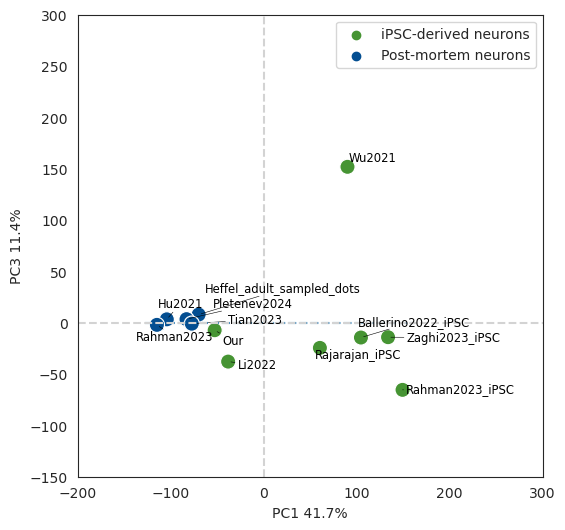

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


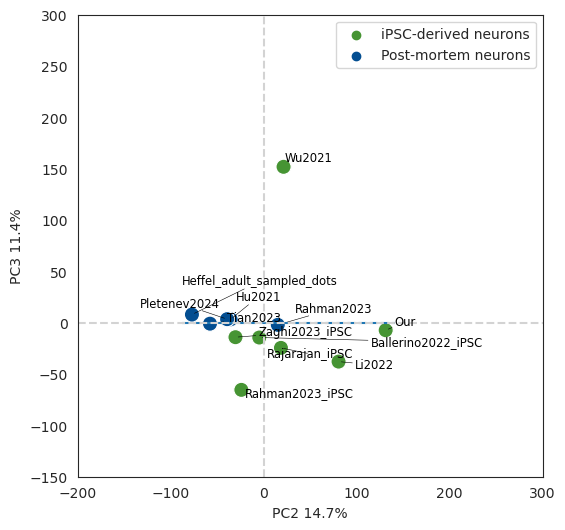

In [54]:
merged_all_clusters_pm_cultures = fullstack_cluster_calculation(bedpe_files_merged, file_to_filter, save_name, add_ipcs_rahman,  selected_groups = ['Post-mortem neurons', 'iPSC-derived neurons'],make_parallel = True, reduced_filtering=False, known_files_num = False)
